In [1]:
from google.colab import userdata

github_token = userdata.get("GITHUB_TOKEN")

# Install the private repository using the token
! pip install nnsight -q
!pip install --upgrade git+https://{github_token}@github.com/withmartian/TinySQL.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.4 MB/s eta 0:00:00
  Cloning https://****@github.com/withmartian/TinySQL.git to /tmp/pip-req-build-3cbikkpk
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/TinySQL.git' /tmp/pip-req-build-3cbikkpk
  Resolved https://****@github.com/withmartian/TinySQL.git to commit f04f5f518763c0d44cc2cc3970531aec0177c03b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TinySQL: filename=TinySQL-1.0-py3-none-any.whl size=43803 sha256=1efd0bb9371ead83c128b9c7f8fcfc822d93a822673fd6eed34d5aed9a7a22c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-p27jh5dk/wheels/a9/72/1c/ba39c57a9acd2e1efd9554f1a2ed8d8987923fbad44ab80971
Successfully built TinyS

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device('cuda')
model_loc = "withmartian/sql_interp_bm1_cs1_experiment_1.1"
tokenizer_sql = AutoTokenizer.from_pretrained(
        model_loc)

model_sql = AutoModelForCausalLM.from_pretrained(
    model_loc,
    torch_dtype=torch.float32,
    device_map='auto',
)
model_sql = model_sql.to(device)

tokenizer_config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/315M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [12]:
def is_in_tiny_stories_vocab(word, tokenizer):
    word = word.lower()

    tokens = tokenizer.encode(word, add_special_tokens=False)

    return len(tokens) == 1

words_ts = [
           "select", "show", "pick", "find",
           "pull", "grab", "take", "move", "walk",
           "run", "jump", "stop", "sing", "fly"
       ]

for word in words_ts:
  print(is_in_tiny_stories_vocab(word, tokenizer_sql))

True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [21]:
base_item = CorruptFeatureTestGenerator(1)._make_base_item()
base_prompt = base_item.get_alpaca_prompt().replace("show me", "select")

In [22]:
base_prompt

'### Instruction:\nselect the name and price from the people table\n### Context:\nCREATE TABLE people ( name JSON, price CHAR )\n### Response:\n'

In [67]:
import matplotlib.pyplot as plt
from TinySQL.corrupt_data.clean_corrupt_data import CorruptFeatureTestGenerator

class SimpleSimilarityTester(CorruptFeatureTestGenerator):
   def __init__(self, generate_fn, corruption='EngFieldStart', *args, **kwargs):
       super().__init__(*args, **kwargs)
       self.generate = generate_fn
       self.test_words = [
           "select", "show", "pick", "find",
           "pull", "grab", "take", "move", "walk",
           "run", "jump", "stop", "sing", "fly", 'create'
       ]
       self.test_separators = [
           ",", ";", "&", "|", ":",
           "#", "@", "$", "^", "~",
           "+", "->", "=>", "--", "//", 'and'
       ]
       self.corruption = corruption
   def test_breakdown(self):
       base_item = self._make_base_item()
       base_prompt = base_item.get_alpaca_prompt().replace("show me", "select")
       base_output = self.generate(base_prompt).split()
       results = []

       if self.corruption == 'EngFieldStart':
          print('corrupting EngFieldStart')

          word_similarities = [(word, self.compute_similarity("select", word))
                            for word in self.test_words]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("select", word)
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))


       if self.corruption == 'DefCreateTable':
          print('corrupting DefCreateTable')

          word_similarities = [(word, self.compute_similarity("create", word))
                            for word in self.test_words]
          word_similarities.sort(key=lambda x: x[1])

          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("CREATE", word.upper())
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))
              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))

       if self.corruption == 'EngFieldSeparator':
          print('corrupting EngFieldSeparator')

          word_similarities = [(word, self.compute_similarity("and", word))
                            for word in self.test_separators]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("and", word)
              corrupt_output = self.generate(corrupted_prompt).split()
              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))


       if self.corruption == 'DefFieldSeparator':
          print('corrupting DefFieldSeparator')
          word_similarities = [(word, self.compute_similarity(",", word))
                            for word in self.test_separators]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace(",", word)
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))



       self.plot_results(results, word_similarities)
       return results

   def compute_similarity(self, str1: str, str2: str) -> float:
       inputs1 = tokenizer_sql(str1, return_tensors='pt', padding=True).to(model_sql.device)
       inputs2 = tokenizer_sql(str2, return_tensors='pt', padding=True).to(model_sql.device)

       with torch.no_grad():
           embeddings1 = model_sql.transformer(inputs1.input_ids).last_hidden_state.mean(dim=1)
           embeddings2 = model_sql.transformer(inputs2.input_ids).last_hidden_state.mean(dim=1)

       similarity = torch.cosine_similarity(embeddings1, embeddings2)
       return similarity.item()

   def plot_results(self, results, word_similarities):
       output_color = "#8ECAE6"  # Soft blue
       input_color = "#A06CD5"   # Medium purple


       sorted_results = [(w, out_sim) for (w, _), (_, out_sim)
                        in sorted(zip(word_similarities, results),
                                key=lambda x: x[0][1], reverse=True)]

       words, output_sims = zip(*sorted_results)
       input_sims = [sim for _, sim in sorted(word_similarities,
                                            key=lambda x: x[1],
                                            reverse=True)]

       plt.figure(figsize=(12, 6))
       plt.plot(range(len(words)), output_sims, color=output_color, ls='-', marker='o', label='Output Similarity')
       plt.plot(range(len(words)), input_sims, color=input_color, ls='--', marker='s', label='Input Similarity')
       plt.xticks(range(len(words)), words, rotation=45)

       for i, (out_sim, in_sim) in enumerate(zip(output_sims, input_sims)):
           plt.text(i, out_sim, f'{out_sim:.3f}', ha='center', va='bottom', color=output_color)
           plt.text(i, in_sim, f'{in_sim:.3f}', ha='center', va='bottom', color=input_color)

       plt.xlabel(f'{self.corruption} (Ordered by Input Similarity)')
       plt.ylabel('Similarity Score')
       plt.title(f'Model Sensitivity to {self.corruption} Substitution')
       plt.legend()
       plt.grid(True, alpha=0.3)
       plt.tight_layout()
       plt.savefig(f'{self.corruption}_breakdown.png', dpi=300)
       plt.show()

def generate_wrapper(prompt):
   inputs = tokenizer_sql(prompt, return_tensors='pt', padding=True).to(model_sql.device)
   outputs = model_sql.generate(
       inputs.input_ids,
       attention_mask=inputs.attention_mask,
       max_new_tokens=100,
       pad_token_id=tokenizer_sql.eos_token_id,
       do_sample=False
   )
   return tokenizer_sql.decode(outputs[0], skip_special_tokens=True)



corrupting DefCreateTable


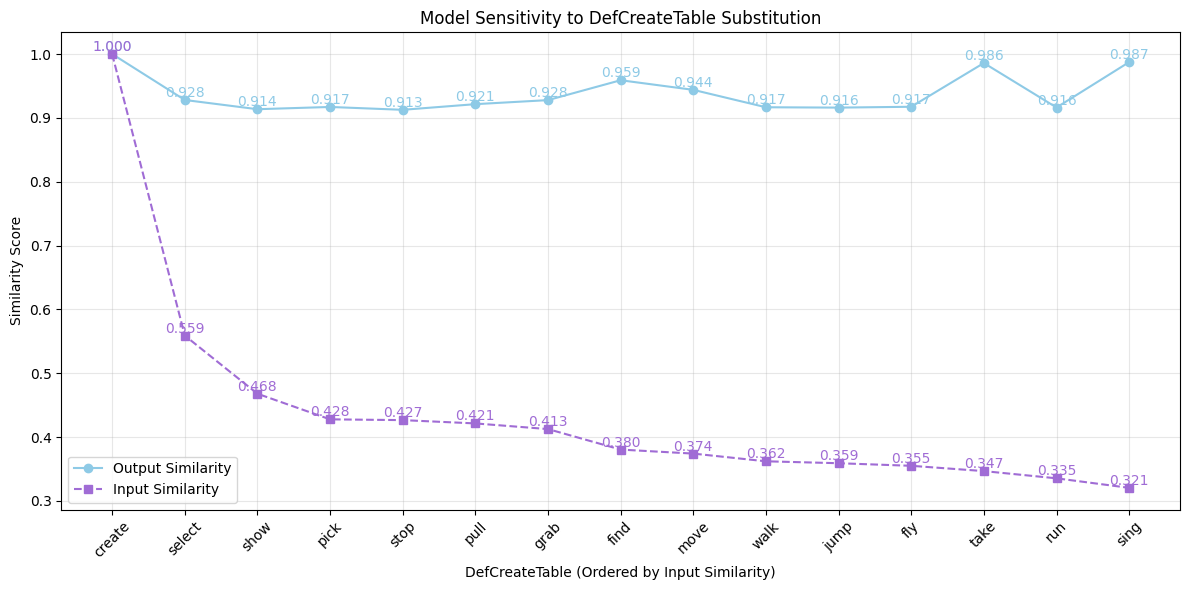

In [64]:
tester = SimpleSimilarityTester(generate_wrapper, "DefCreateTable")
results = tester.test_breakdown()

corrupting EngFieldStart


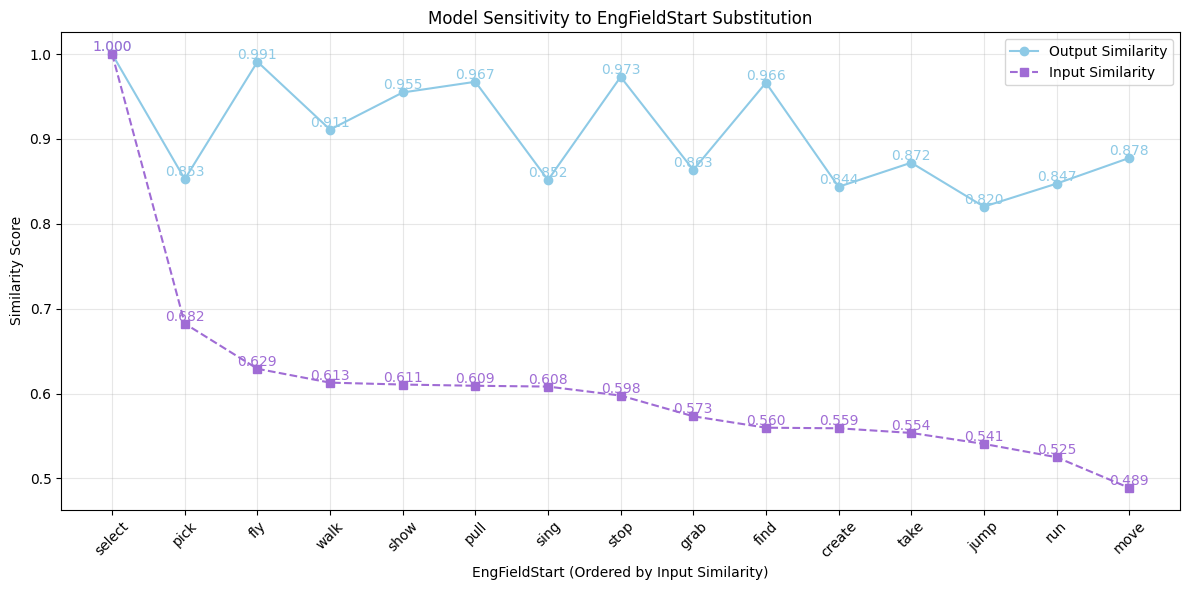

In [65]:
tester = SimpleSimilarityTester(generate_wrapper, "EngFieldStart")
results = tester.test_breakdown()

corrupting EngFieldSeparator


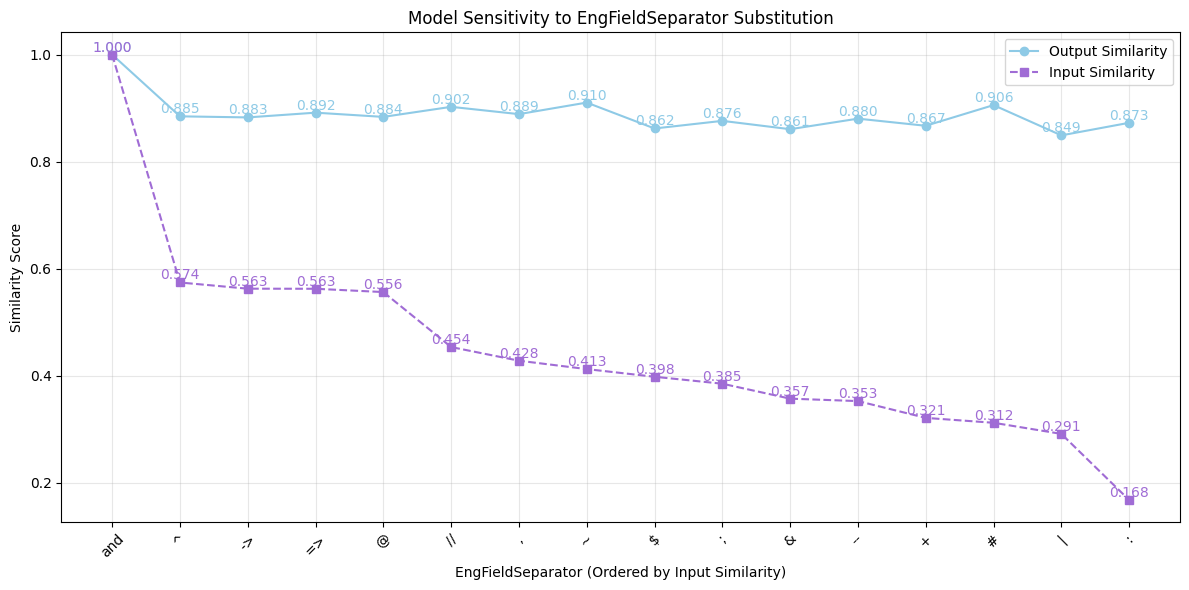

In [68]:
tester = SimpleSimilarityTester(generate_wrapper, "EngFieldSeparator")
results = tester.test_breakdown()

corrupting DefFieldSeparator


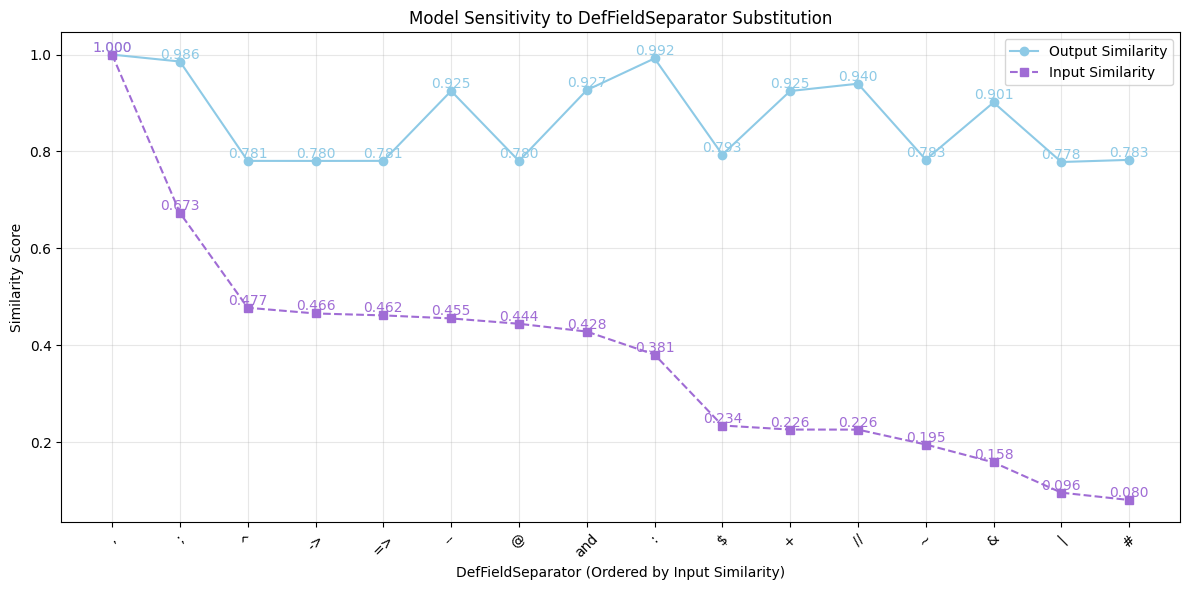

In [66]:
tester = SimpleSimilarityTester(generate_wrapper, "DefFieldSeparator")
results = tester.test_breakdown()